In [1]:
import sympy as sp
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import warnings
from numba.core.errors import NumbaWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=NumbaWarning)
from scipy.optimize import minimize, least_squares

# Load test samples
from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")

from aeons.covariance import logX_mu, logX_covinv_chol, points_at_iteration, X_mu, X_Sigma, X_Sigmainv, data_at_iteration
from aeons.true_distribution import generate_Xs
from aeons.lm_partial import analytic_lm_params
from bayes import logPr_bayes, logPr_gaussian, minimise_ls, minimise_bayes, minimise_gaussian
from likelihoods import likelihood, linear_like, quad_like, log_like, simple_like, middle_like, full_like
linear, quad, log = linear_like(), quad_like(), log_like()
simple, middle, full = simple_like(), middle_like(), full_like()
from hessian import hess

### Obtaining H

Should probably cache analytic expressions to save time

In [122]:
logLmax, d, sigma = sp.symbols('\log{L_\mathrm{max}} d \sigma')
X_i, logL_i, logL_j = sp.symbols('X_i \log{L_i} \log{L_j}')
mu_i, mu_j = sp.symbols('\mu_i, \mu_j')

### Checking results

In [205]:
def minimise_bayes(logL, likelihood, mean, covinv, x0):
    def func(theta):
        return - logPr_bayes(logL, likelihood, mean, covinv, theta)
    solution = minimize(func, x0, method='Nelder-Mead')
    return solution

def logPr_laplace(theta, logpr_max, theta_max, Hessian):
    if len(theta) == 1:
        return float(logpr_max - 1/2 * (theta - theta_max).T * (- Hessian) * (theta - theta_max))
    return logpr_max - 1/2 * (theta - theta_max).T @ (- Hessian) @ (theta - theta_max) # A = negative hessian

In [208]:
nk = 500 * np.ones(200)
mean_X = X_mu(nk)
covinv_X = X_Sigmainv(nk)
X = generate_Xs(nk)
theta_true = np.array([1, 10, 1])
y = full.func(X, theta_true)
theta_max = minimise_bayes(y, full, mean_X, covinv_X, theta_true).x
logLmax0, d0, sigma0 = theta_max
theta_max

array([ 0.93686234, 10.17203283,  1.06976609])

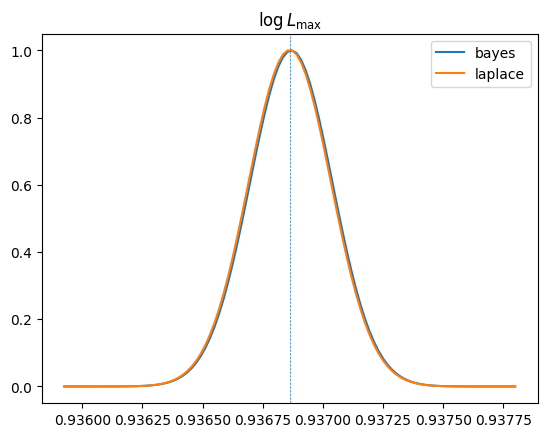

In [209]:
logLmaxs = np.linspace(logLmax0*0.999, logLmax0*1.001, 100)
prs_bayes = np.zeros_like(logLmaxs)
prs_laplace = np.zeros_like(logLmaxs)
logprmax = logPr_bayes(y, full, mean_X, covinv_X, theta_max)

H = hess(y, mean_X, covinv_X, theta_max, logLmax, logLmax)

for i, logLmax_ in enumerate(logLmaxs):
    prs_bayes[i] = logPr_bayes(y, full, mean_X, covinv_X, [logLmax_, d0, sigma0])
    prs_laplace[i] = logPr_laplace(np.array([logLmax_]), logprmax, logLmax0, H)

plt.plot(logLmaxs, np.exp(prs_bayes - prs_bayes.max()), label='bayes')
plt.plot(logLmaxs, np.exp(prs_laplace - prs_laplace.max()), label='laplace')
# plt.plot(logLmaxs, prs_bayes, label='bayes')
# plt.plot(logLmaxs, prs_laplace, label='laplace')
plt.axvline(x=logLmax0, ls='--', lw=.5)
plt.title('$\log{L_\mathrm{max}}$')
plt.legend();

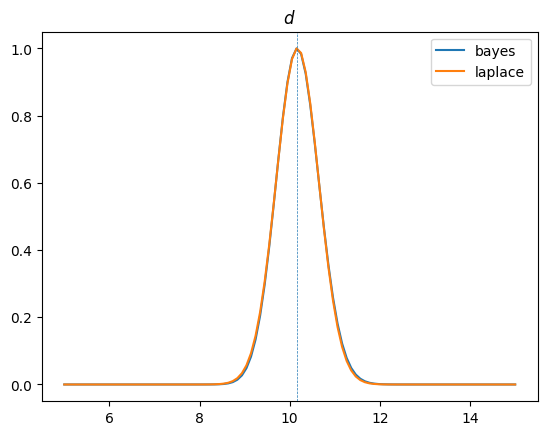

In [210]:
ds = np.linspace(5, 15, 100)
prs_bayes = np.zeros_like(ds)
prs_laplace = np.zeros_like(ds)
logprmax = logPr_bayes(y, full, mean_X, covinv_X, theta_max)

H = hess(y, mean_X, covinv_X, theta_max, d, d)

for i, d_ in enumerate(ds):
    prs_bayes[i] = logPr_bayes(y, full, mean_X, covinv_X, [logLmax0, d_, sigma0])
    prs_laplace[i] = logPr_laplace(np.array([d_]), logprmax, d0, H)

plt.plot(ds, np.exp(prs_bayes - prs_bayes.max()), label='bayes')
plt.plot(ds, np.exp(prs_laplace - prs_laplace.max()), label='laplace')
# plt.plot(thetas, prs_bayes, label='bayes')
# plt.plot(thetas, prs_laplace, label='laplace')
plt.axvline(x=d0, ls='--', lw=.5)
plt.title('$d$')
plt.legend();

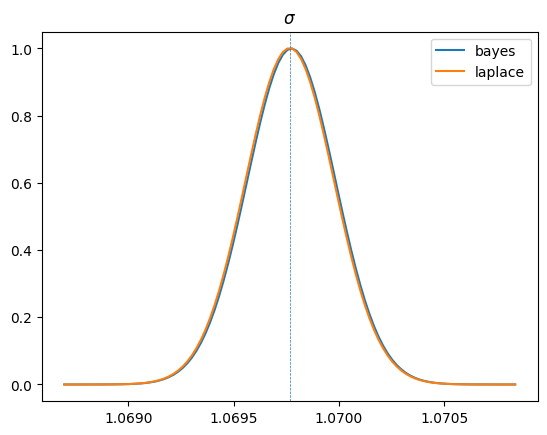

In [211]:
thetas = np.linspace(sigma0*0.999, sigma0*1.001, 100)
prs_bayes = np.zeros_like(thetas)
prs_laplace = np.zeros_like(thetas)
logprmax = logPr_bayes(y, full, mean_X, covinv_X, theta_max)

H = hess(y, mean_X, covinv_X, theta_max, sigma, sigma)

for i, theta in enumerate(thetas):
    prs_bayes[i] = logPr_bayes(y, full, mean_X, covinv_X, [logLmax0, d0, theta])
    prs_laplace[i] = logPr_laplace(np.array([theta]), logprmax, sigma0, H)

plt.plot(thetas, np.exp(prs_bayes - prs_bayes.max()), label='bayes')
plt.plot(thetas, np.exp(prs_laplace - prs_laplace.max()), label='laplace')
# plt.plot(thetas, prs_bayes, label='bayes')
# plt.plot(thetas, prs_laplace, label='laplace')
plt.axvline(x=sigma0, ls='--', lw=.5)
plt.title('$\sigma$')
plt.legend();

In [102]:
H

-77453694.89904757

In [ ]:
theta = [logLmax, d, sigma]
for t1 in theta

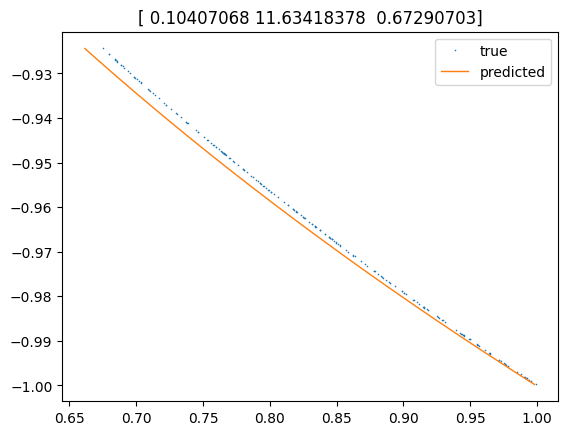

In [64]:
X_b = full.inverse(y, theta_max)
plt.plot(X, y, 'x', ms=.5, label='true')
plt.plot(X_b, y, lw=1, label='predicted')
plt.title(theta_max)
plt.legend();

In [ ]:
k = len(logL)
quad = 0
for i in range(k):
    quad += hess_cross_ij(d, d)(logL[i], logL, mean_X[i], mean_X, *theta_max).sum()
    print(i)